In [150]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import itertools

In [151]:
def generate_all_policies(diagram, decision_node): # get all possible strategies (policies) for a decision node
    parent_ids = diagram.parents(decision_node)
    parent_domains = [range(diagram.variable(p).domainSize()) for p in parent_ids]
    decision_domain = range(diagram.variable(decision_node).domainSize())

    policies = []
    for mapping in itertools.product(decision_domain, repeat=int(pow(len(decision_domain), len(parent_ids)))):
        policy = {}
        for parents_values, decision_value in zip(itertools.product(*parent_domains), mapping):
            policy[parents_values] = decision_value
        policies.append(policy)
    return policies

def get_node_domain_sizes(diagram):
    return {n: diagram.variable(n).domainSize() for n in diagram.nodes() if not diagram.isUtilityNode(n)}

def generate_all_assignments(diagram):
    domain_sizes = get_node_domain_sizes(diagram)

    var_ids = list(domain_sizes.keys())
    var_names = [diagram.variable(n).name() for n in var_ids]
    var_domains = [range(domain_sizes[n]) for n in var_ids]

    all_combinations = itertools.product(*var_domains)

    all_assignments = []
    for combo in all_combinations:
        assignment = {}
        for i in range(len(var_names)):
            assignment[var_names[i]] = combo[i]
        all_assignments.append(assignment)

    return all_assignments

def compute_meu(id): # for just ids with one decision node (for now)
    decision_nodes = [node for node in id.nodes() if id.isDecisionNode(node)]
    if len(decision_nodes) != 1:
        return
    
    policies = generate_all_policies(id, decision_nodes[0])

    for policy in policies:
        eu = 0
        assignments = generate_all_assignments(id)
        for a in assignments:
            pass
        
# NOT DONE YET BUT I HAVE A VISION I JUST NEED SLEEP

In [152]:
id = gum.InfluenceDiagram()

rain = id.addChanceNode(gum.LabelizedVariable("Rain", 'rain', ['No', 'Yes']))
umbrella = id.addDecisionNode(gum.LabelizedVariable("Umbrella", 'umbrella', ['Take', 'Dont take']))
utility = id.addUtilityNode(gum.LabelizedVariable("am i happy", 'am i tho', 1))

id.cpt(rain)[{'Rain':'No'}] = 0.7
id.cpt(rain)[{'Rain':'Yes'}] = 0.3

id.addArc(rain, umbrella)
#id.addArc(rain, utility)
id.addArc(umbrella, utility)

u = id.utility(utility)
u[{'Rain':'No', 'Umbrella':'Dont take'}] = 10
u[{'Rain':'No', 'Umbrella':'Take'}] = 7   
u[{'Rain':'Yes', 'Umbrella':'Dont take'}] = 0   
u[{'Rain':'Yes', 'Umbrella':'Take'}] = 9

'''policy, meu = compute_meu(id)

print("MEU:", meu)
print("Best Policy:", policy)'''

'policy, meu = compute_meu(id)\n\nprint("MEU:", meu)\nprint("Best Policy:", policy)'

In [153]:
get_node_domain_sizes(id)

{0: 2, 1: 2}

In [154]:
ewe = gum.ShaferShenoyLIMIDInference(id) 
ewe.makeInference()
print(ewe.MEU())
print(ewe.optimalDecision(umbrella))

{'mean': 9.0, 'variance': 0.0}

  Umbrella         |
Take     |Dont take|
---------|---------|
 1.0000  | 0.0000  |



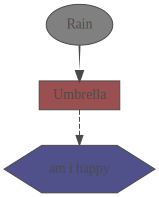

In [155]:
gnb.showInfluenceDiagram(id)